# 피마 인디언 당뇨병 예측

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1 스코어를 추가
    f1 = f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1스코어 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축:threshold값, y축:정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #X축, Y축 label과 legend, 그리고 gird 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        print("<임계값 : {0}>".format(custom_threshold))
        #predict_proba() 반환값의 두번째 칼럼(1로 예측한 확률)만을 추출해 Binarizer를 적용해 최종 예측값을 구한다.

        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        get_clf_eval(y_test, custom_predict, pred_proba_c1) #임계값을 0.5로 설정 후 테스트 데이터와 비교한다.

diabetes_data = pd.read_csv('Kaggle_Ex/pima-indians-diabetes/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [87]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 1. 로지스틱 회귀를 이용 & 데이터 전처리

In [88]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]
#stratify 옵션 : train, test 데이터가 label y의 비율을 유지하도록 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y) 

#로지스틱 회귀로 학습 및 평가
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1스코어 : 0.6804, AUC : 0.8072


# 2. 성능 평가 지표 및 재현율 곡선 시각화

## - 정밀도, 재현율 곡선 시각화

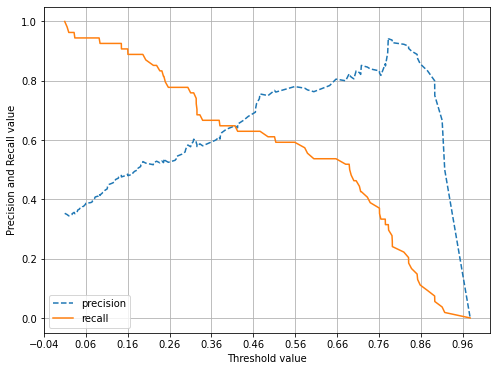

In [89]:
precision_recall_curve_plot(y_test, pred_proba)

임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것으로 보이지만, 정밀도와 재현율이 0.7이 안되는 수치를 보이므로 두 지표의 값이 너무 낮다.

### *임계값 조정 전 다시 데이터 값 분석하기

In [90]:
diabetes_data.describe() # 각 feature의 특성 분포도 확인

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


데이터를 보면 min() 값이 0인 값들이 굉장히 많다. 각 특성이 0이 되면 안될 것 같은 특성을 하나씩 살펴보자.

#### Glucose

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

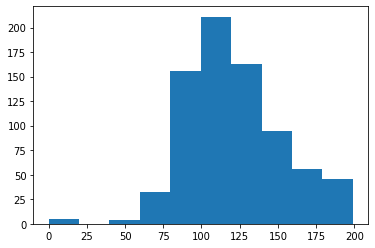

In [91]:
plt.hist(diabetes_data['Glucose'], bins = 10) #bins는 가로축 개수를 의미한다.

#### Glucose 포함 다른 feature의 0값의 건수 및 전체 데이터 건수 대비 비율을 알아보자

In [92]:
#0값을 검사할 피쳐 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

#전체 데이터 건수
total_count = diabetes_data['Glucose'].count()
#피쳐별로 반복하면서 데이터 값이 0인 값 추출 및 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0}  0 건수는 {1}, 퍼센트는 {2:.2f}% '.format(feature, zero_count, zero_count/total_count*100))

Glucose  0 건수는 5, 퍼센트는 0.65% 
BloodPressure  0 건수는 35, 퍼센트는 4.56% 
SkinThickness  0 건수는 227, 퍼센트는 29.56% 
Insulin  0 건수는 374, 퍼센트는 48.70% 
BMI  0 건수는 11, 퍼센트는 1.43% 


SkinThickness와 Insulin의 0값이 다른 feature들보다 대단히 많다는 것을 확인할 수 있다. 이 0 값들을 삭제해버리는 경우 데이터의 양이 너무 줄어 제대로된 학습이 진행될 수 없으므로 해당 0값을 <strong>평균값</strong>으로 대체하도록 하자.

## - 0 값을 평균값으로 대체

In [93]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

## - 데이터 셋에 피처 스케일링 적용

In [94]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 피처스케일링 이후 다시 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1스코어 : 0.6804, AUC : 0.8433


#### <0값 대체 및 피처 스케일링 이전 성능>
오차행렬 <br>
[[90 10] <br>
 [21 33]] <br>
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1스코어 : 0.6804, AUC : 0.8072

조금이지만, 성능 수치가 개선된 것을 확인할 수 있다. <br>
하지만 여전히 재현율 수치는 개선이 필요하다.

## - 정밀도와 재현율의 수치를 높이기 위해 각 임계값 별로 평가 수치를 출력한뒤, 최적의 임계값을 찾는다.

In [95]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

<임계값 : 0.3>
오차행렬
[[67 33]
 [11 43]]
정확도 : 0.7143, 정밀도 : 0.5658, 재현율 : 0.7963, F1스코어 : 0.6615, AUC : 0.8433
<임계값 : 0.33>
오차행렬
[[72 28]
 [12 42]]
정확도 : 0.7403, 정밀도 : 0.6000, 재현율 : 0.7778, F1스코어 : 0.6774, AUC : 0.8433
<임계값 : 0.36>
오차행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222, F1스코어 : 0.6667, AUC : 0.8433
<임계값 : 0.39>
오차행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037, F1스코어 : 0.6667, AUC : 0.8433
<임계값 : 0.42>
오차행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667, F1스코어 : 0.6792, AUC : 0.8433
<임계값 : 0.45>
오차행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667, F1스코어 : 0.6857, AUC : 0.8433
<임계값 : 0.48>
오차행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1스코어 : 0.6931, AUC : 0.8433
<임계값 : 0.5>
오차행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1스코어 : 0.6804, AUC : 0.8433


피처스케일링 이후 성능인 <br>
<strong>
오차행렬 <br>
[[90 10] <br>
 [21 33]] <br>
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1스코어 : 0.6804, AUC : 0.8433 <br>
</strong>
과 비교했을때, 다른 평가지표는 유지하면서, 재현율이 살짝올라간 임계값 0.48이 가장 적절한 성능 향상이라 볼 수 있으므로 임계값을 0.48로하고  예측을 재진행한다.

# 3. <결과>

In [109]:
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1스코어 : 0.6931, AUC : 0.8433
